In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mpl_col
import matplotlib.cm as cm
import seaborn as sns
import re
from IPython.display import display

In [4]:
import pop_stats_plotting_tools as pt
from matplotlib_venn import venn2

# Plotting settings

In [5]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', 200)

In [6]:
sns.set_context("paper")
sns.set(font_scale=1.5, font='Arial')

In [7]:
import matplotlib.colors as mpl_col
import matplotlib.cm as cm
cpool = ["#cccccc", "#B6B6B6", "#424B80", "#440647"]
cmap3 = mpl_col.ListedColormap(cpool, 'indexed')
cm.register_cmap(cmap=cmap3)

# Constants

In [8]:
SUPPLEMENT_PATH = "./supp_data/"
RAW_FIGURE_PATH = "./raw_figure/"

In [9]:
GENES = "./data/genes.txt"
DRUGS = "./data/compounds.txt"
DRUG2GENE = "./data/compound2gene.txt"
DRUG2VARIANT = "./data/variant2compound.txt"
IUPHAR = "./data/IUPHAR_drug2genes_200516.csv"
TOP100 = "./data/drugs_drugscom_top100_sales_annotated_v2.txt"
TOP100_UNITS = "./data/drugs_drugscom_top100_units_annotated.txt"
ESSENTIAL_MEDS = "./data/who_essential_medicines_042015.txt"
KOZYRA_SUPP_DATA = "./data/gim201633x1_Supplementary_Table2_revision.xls"
FUJIKURA_SUPP_DATA = "./data/FPC_2015_08_04_FUJIKURA_PGEN-2015-044_SDC5.xls"
PHARMAADME_SUPP_DATA = "./data/pharmaadme_core.xlsx"
OVERINGTON_SUPP_DATA = "./data/overington_nrd.2016.230-s2.xlsx"

In [10]:
COLOR_MAPPING = {"Target": "#A6002C", "target": "#A6002C", "Target genes": "#A6002C",
                 "ADME": "#6C226C", 'other ADME genes': "#6C226C",
                 "Cytochrome": "#2A3FA6", 'Cytochrome P450s': "#2A3FA6",
                 "All genes": "grey"}

# Functions

In [11]:
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [12]:
def reduce_drug2gene(df):
    rdf = df.groupby(['hgnc_id', 'gene_symbol'])\
            .agg({'midrug_id': {'drug_ids': lambda x: ','.join(map(str, x))},
                  'name': {'drug_names': lambda x: ','.join(set(x)),
                           ' n_drugs': lambda x: len(set(x))}})\
            .reset_index()
    return rdf

# Data Imports

## Gene data

In [13]:
genes = pd.read_csv(GENES, sep="\t", comment="#")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Drug data

In [14]:
drugs = pd.read_csv(DRUGS, sep="\t", encoding='utf-8', quotechar='"', skiprows=2)

In [15]:
# extract drug synonyms for mapping
midrug_synonyms = pd.DataFrame([(y[0], x.lower()) for y in zip(drugs.midrug_id, drugs.synonyms.tolist())
                                if type(y[1]) != float for x in y[1].split("|")], columns=["midrug_id", "synonym"])
midrug_synonyms['name'] = midrug_synonyms['synonym'].str.lower() 

### Cancer drugs
ATC code with super-category L stand for antineoplastic and immunomodulatory indications
(http://www.whocc.no/atc_ddd_index/?code=L&showdescription=yes)

They are further grouped in 
* L01: antineoplastic agents
* L02: endocrine therapy with anti-neoplastic goal
* L03: immunostimulants -- also includes cancer drugs
* L04: immunosuppressants -- also includes cancer drugs

In [16]:
drug2atc = pd.concat([pd.Series(row['midrug_id'], row['ATC'].split('|'))              
                      for _, row in drugs.dropna(subset=["ATC"]).iterrows()])\
             .reset_index().rename(columns={"index":"ATC", 0: "midrug_id"})

In [17]:
onco_drugs = drug2atc.loc[drug2atc.ATC.str.startswith("L")].midrug_id.unique()
other_drugs = drug2atc.loc[~drug2atc.ATC.str.startswith("L", na=False)].midrug_id.unique()
# exclude those drugs that have a non-neoplastic ATC code
onco_only_drugs = [d for d in onco_drugs if d not in other_drugs]

In [18]:
print len(onco_drugs), "drugs indicated for cancer + maybe other diseases"
print len(onco_only_drugs), "drugs only indicated for cancer"
print len(other_drugs), "non-cancer drugs"

228 drugs indicated for cancer + maybe other diseases
218 drugs only indicated for cancer
1702 non-cancer drugs


## Drug - gene interaction data

In [19]:
drug2gene = pd.read_csv(DRUG2GENE, sep="\t", comment="#", quotechar='"')
drug2gene = drug2gene.merge(drugs[['midrug_id', 'name', 'drugbank_id', 'ATC', 'isFdaApproved',
                                   'isWithdrawn', 'categories']],
                            left_on="midrug_id", right_on="midrug_id")
drug2gene = drug2gene.merge(genes[["hgnc_id", "symbol"]], on="hgnc_id").rename(columns={'symbol': 'gene_symbol'})

In [20]:
iuphar_targets_approved_drugs = pd.read_csv(IUPHAR, sep="\t")
iuphar_targets_approved_drugs = iuphar_targets_approved_drugs[["type", "action", "action_comment",
                                                               "primary_target", "endogenous", "hgnc_id",
                                                               "drugbank_id"]]

In [21]:
# add IUPHAR drug - gene links to data set
drug2gene_annot = drug2gene.merge(iuphar_targets_approved_drugs,
                                  on=["drugbank_id", "hgnc_id"],
                                  how="left")\
                           .drop_duplicates(subset=['hgnc_id', 'midrug_id'])

In [22]:
print drugs.midrug_id.nunique(), 'drugs (drugbank)'
print drug2gene.midrug_id.nunique(), 'drugs (drugbank) with genetic information'

8221 drugs (drugbank)
5185 drugs (drugbank) with genetic information


In [23]:
approved_drugs = drugs.loc[drugs.isFdaApproved == 1]
print approved_drugs.midrug_id.nunique(), "approved drugs (drugbank)"
prim_assoc = drug2gene_annot.loc[drug2gene_annot.primary_target == 't']
print len(prim_assoc), "primary target associations (", prim_assoc.midrug_id.nunique(),
print "drugs ) mapped from IUPHAR to drugbank associations"

2234 approved drugs (drugbank)
851 primary target associations ( 607 drugs ) mapped from IUPHAR to drugbank associations


In [24]:
# create MultiIndex
t = [(cn, '' ) for cn in drug2gene_annot.columns]
c = pd.MultiIndex.from_tuples(t)
drug2gene_annot.columns = c

Exclude wrong annotations from dataset

In [25]:
# exclude CACNA1S
drug2gene_annot = drug2gene_annot.loc[drug2gene_annot.hgnc_id != 1397]

In [26]:
#exclude hyaloronic acid and ethanol
exclude_drug_ids = drugs.loc[drugs.name.isin(["Ethanol", 'Hyaluronic acid'])].midrug_id.tolist()
drug2gene_annot = drug2gene_annot.loc[~drug2gene_annot.midrug_id.isin(exclude_drug_ids)]

In [27]:
print drug2gene_annot.loc[drug2gene_annot.isFdaApproved == 1]['midrug_id'].nunique(), "approved drugs total &",
print drug2gene_annot.loc[drug2gene_annot.isFdaApproved == 1]['hgnc_id'].nunique(), "associated genes."

1665 approved drugs total & 1701 associated genes.


### Cancer only

In [28]:
drug2gene_annot_onco =  drug2gene_annot.loc[drug2gene_annot.midrug_id.isin(onco_only_drugs)]

In [29]:
print drug2gene_annot_onco.loc[drug2gene_annot_onco.isFdaApproved == 1]['midrug_id'].nunique(), "approved cancer drugs",
print "&", drug2gene_annot_onco.loc[drug2gene_annot_onco.isFdaApproved == 1]['hgnc_id'].nunique(), "associated genes."

193 approved cancer drugs & 380 associated genes.


### Approved and established subsets

In [30]:
# all targets of approved drugs
drug2gene_targets_all = drug2gene_annot.loc[(drug2gene_annot.association_type == "target")]
drug2gene_targets_all_approved_drugs = drug2gene_targets_all.loc[drug2gene_targets_all.isFdaApproved == 1]
targets_all_approved_drugs = reduce_drug2gene(drug2gene_targets_all_approved_drugs)

# established targets of approved drugs
drug2gene_targets = drug2gene_annot.loc[(drug2gene_annot.association_type == "target") &
                                        (drug2gene_annot.target_known_action == 1)]
drug2gene_targets_approved_drugs = drug2gene_targets.loc[drug2gene_targets.isFdaApproved == 1]
targets_approved_drugs = reduce_drug2gene(drug2gene_targets_approved_drugs)

In [31]:
print len(drug2gene_targets_approved_drugs), "established target links for approved drugs", 
print "(", drug2gene_targets_approved_drugs.midrug_id.nunique(), "drugs,", 
print drug2gene_targets_approved_drugs.hgnc_id.nunique(), "genes)"

2652 established target links for approved drugs ( 1238 drugs, 636 genes)


### Drugs per target

In [32]:
drugbank_pairs = zip(drug2gene_targets_approved_drugs.midrug_id.tolist(), drug2gene_targets_approved_drugs.hgnc_id.tolist())

In [33]:
print drug2gene_targets_approved_drugs.groupby("midrug_id").agg({"hgnc_id": lambda x: len(set(x))})["hgnc_id"].mean(),
print "established targets per approved drug on average"

2.14216478191 established targets per approved drug on average


In [34]:
print 'drugs'
print drug2gene_targets_all.midrug_id.nunique(), "(any, with any target data)"
print drug2gene_targets_all_approved_drugs.midrug_id.nunique(), "(approved, with any target data)"
print drug2gene_targets.midrug_id.nunique(), "(any, with established target data)"
print drug2gene_targets_approved_drugs.midrug_id.nunique(), "(approved, with established target data)"

drugs
4845 (any, with any target data)
1460 (approved, with any target data)
1297 (any, with established target data)
1238 (approved, with established target data)


In [35]:
print 'targets'
print drug2gene_targets_all.hgnc_id.nunique(), "(targets)"
print drug2gene_targets_all_approved_drugs.hgnc_id.nunique(), "(targets for approved drugs)"
print drug2gene_targets.hgnc_id.nunique(), "(established targets)"
print drug2gene_targets_approved_drugs.hgnc_id.nunique(), "(established targets for approved drugs)",

targets
2353 (targets)
1491 (targets for approved drugs)
647 (established targets)
636 (established targets for approved drugs)


In [36]:
drug2gene_onco_targets_approved_drugs = drug2gene_annot_onco.loc[(drug2gene_annot_onco.association_type == "target") &
                                                                 (drug2gene_annot_onco.target_known_action == 1) &
                                                                 (drug2gene_annot_onco.isFdaApproved == 1)]

In [37]:
print len(drug2gene_onco_targets_approved_drugs), "established target links for approved cancer drugs", 
print "(", drug2gene_onco_targets_approved_drugs.midrug_id.nunique(), "drugs,", 
print drug2gene_onco_targets_approved_drugs.hgnc_id.nunique(), "genes)"

310 established target links for approved cancer drugs ( 152 drugs, 163 genes)


## Drug - variant data

In [38]:
pharmgkb_pgx_data = pd.read_csv(DRUG2VARIANT, sep="\t", skiprows=2)
pharmgkb_pgx_data["Gene Symbols"] = pharmgkb_pgx_data["gene_symbols"].apply(lambda x: x.strip() if type(x) == str else x)

In [39]:
pharmgkb_genes_all = [g for x in pharmgkb_pgx_data.dropna(subset=["Gene Symbols"])["Gene Symbols"].unique()
                      for g in x.split(",")]

In [40]:
# only those interactions with a significant association in the data set
significant_genes = list(set([g for x in pharmgkb_pgx_data.loc[pharmgkb_pgx_data.significance.str.contains('yes', na=False)]\
                     .dropna(subset = ["Gene Symbols"])["Gene Symbols"].unique() for g in x.split(",")]))
significant_drugs = pharmgkb_pgx_data.loc[pharmgkb_pgx_data.significance.str.contains('yes', na=False)].midrug_id.unique()
pharmgkb_drugs = drugs.loc[drugs.midrug_id.isin(significant_drugs)]
significant_drug_names = [str(x) for x in pharmgkb_drugs.name.unique()]

In [41]:
pgx_gene_drug_pairs = [(row["midrug_id"], row["Gene Symbols"]) for i, row in pharmgkb_pgx_data.iterrows()]

In [42]:
print "Total of", len(pgx_gene_drug_pairs), "PGx associations in PharmGKB,"
print "including", len(significant_genes), "genes in PharmGKB with significant association and"
print len(significant_drugs), "mapped drugs."

Total of 18880 PGx associations in PharmGKB,
including 857 genes in PharmGKB with significant association and
361 mapped drugs.


In [43]:
pgx_genes_for_drug = pharmgkb_pgx_data.loc[pharmgkb_pgx_data.significance.str.contains('yes', na=False)]\
    .dropna(subset=['Gene Symbols'])\
    .groupby('midrug_id')\
    .agg({'Gene Symbols': lambda x: [y for z in x for y in z.split(',')]})\
    .reset_index()

In [44]:
print len(pgx_genes_for_drug), "compounds with established pgx data from pharmGKB."

358 compounds with established pgx data from pharmGKB.


## Top selling drugs

### By $$$

In [45]:
top_100_sales_data = pd.read_csv(TOP100, skiprows=5, sep="\t")
top_100_sales_data.drop('midrugID', axis=1, inplace=True)
top_100_sales_drugs = top_100_sales_data.groupby(['name', 'drugbank_id', 'PharmGKB'])\
                               .agg({'Drug': {'name': lambda x: ', '.join(set(x)),
                                              'count': lambda x: len(set(x))},
                                     'Rank': {'top': np.min, 'mean': np.mean,
                                              'all': lambda x: ', '.join(map(str, set(x)))}})\
                               .reset_index()
top_100_sales_drugs.columns = ['_'.join(col).strip() for col in top_100_sales_drugs.columns.values]
top_100_sales_drugs = top_100_sales_drugs.merge(drugs[['name', 'midrug_id', 'drugbank_id']],
                                                left_on='drugbank_id_', right_on='drugbank_id')
top_100_sales_drugs.drop(['name', 'drugbank_id'], axis=1, inplace=True)
top_100_sales_drugs['name_'] = top_100_sales_drugs['name_'].str.title()
top_100_sales_drugs.columns = ["top100_sales_" + x if "Rank" in x else x for x in top_100_sales_drugs.columns]

In [46]:
print len(top_100_sales_drugs),"compounds in top 100 drugs ($$$) list"

87 compounds in top 100 drugs ($$$) list


In [47]:
drug2gene_targets_approved_drugs_top100_sales = drug2gene_targets.merge(top_100_sales_drugs,
                                                                        left_on='drugbank_id',
                                                                        right_on='drugbank_id_')
top_100_sales_targets = drug2gene_targets_approved_drugs_top100_sales[('gene_symbol', '')].unique()
top_100_sales_compounds = drug2gene_targets_approved_drugs_top100_sales[('midrug_id', '')].unique()

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [48]:
print len(top_100_sales_compounds),
print "compounds in top 100 list ($$$) with id and data for",
print len(top_100_sales_targets), "established targets"

75 compounds in top 100 list ($$$) with id and data for 76 established targets


### By units

In [49]:
top_100_units_data = pd.read_csv(TOP100_UNITS, skiprows=4, sep="\t")
top_100_units_data.drop('midrugID', axis=1, inplace=True)
top_100_units_drugs = top_100_units_data.groupby(['name', 'drugbank_id', 'PharmGKB'])\
                               .agg({'Drug': {'name': lambda x: ', '.join(set(x)),
                                              'count': lambda x: len(set(x))},
                                     'Rank': {'top': np.min, 'mean': np.mean,
                                              'all': lambda x: ', '.join(map(str, set(x)))},
                                     'Units (000)': {'sum': lambda x: np.sum([float(y.replace(',', '')) for y in x if type(y) == str]),
                                                     'indiv': lambda x: '| '.join(map(str, set(x)))}})\
                               .reset_index()
top_100_units_drugs.columns = ['_'.join(col).strip() for col in top_100_units_drugs.columns.values]
top_100_units_drugs = top_100_units_drugs.merge(drugs[['name', 'midrug_id', 'drugbank_id']],
                                                left_on='drugbank_id_', right_on='drugbank_id')\
                                         .drop(['name', 'drugbank_id'], axis=1)
top_100_units_drugs['name_'] = top_100_units_drugs['name_'].str.title()
top_100_units_drugs.columns = ["top100_units_" + x if "Rank" in x else x for x in top_100_units_drugs.columns]

In [50]:
print len(top_100_units_drugs),"compounds in top 100 drugs (units) list"

87 compounds in top 100 drugs (units) list


In [51]:
drug2gene_targets_approved_drugs_top100_units = drug2gene_targets.merge(top_100_units_drugs,
                                                                        left_on='drugbank_id',
                                                                        right_on='drugbank_id_')
top100_units_targets = drug2gene_targets_approved_drugs_top100_units[('gene_symbol', '')].unique()

In [52]:
top_100_units_compounds = drug2gene_targets_approved_drugs_top100_units[('midrug_id', '')].unique()

In [53]:
print len(top_100_units_compounds),
print "compounds in top 100 list (units) with drug id and data for",
print len(top100_units_targets), "established targets"

77 compounds in top 100 list (units) with drug id and data for 80 established targets


### Combined

In [54]:
print "only in top100 by $$$",
print sorted(set(top_100_sales_drugs.name_.tolist()) - set(top_100_units_drugs.name_.tolist()))
print "only in top100 by $$$ with target data", sorted(set(drug2gene_targets_approved_drugs_top100_sales['name_'].tolist()) - set(drug2gene_targets_approved_drugs_top100_units['name_'].tolist()))

only in top100 by $$$ ['Capecitabine', 'Everolimus', 'Imatinib', 'Interferon Beta-1B', 'Telaprevir', 'Ustekinumab']
only in top100 by $$$ with target data ['Capecitabine', 'Everolimus', 'Imatinib', 'Interferon Beta-1B']


In [55]:
print "only in top100 by units",
print sorted(set(top_100_units_drugs.name_.tolist()) - set(top_100_sales_drugs.name_.tolist()))
print "only in top100 by units with target data", sorted(set(drug2gene_targets_approved_drugs_top100_units['name_'].tolist()) - set(drug2gene_targets_approved_drugs_top100_sales['name_'].tolist()))

only in top100 by units ['Atorvastatin', 'Epinephrine', 'Hydrochlorothiazide', 'Naloxone', 'Omeprazole', 'Valproic Acid']
only in top100 by units with target data ['Atorvastatin', 'Epinephrine', 'Hydrochlorothiazide', 'Naloxone', 'Omeprazole', 'Valproic Acid']


In [56]:
print "shared in both lists", len(set(top_100_units_drugs.name_.tolist()) & set(top_100_sales_drugs.name_.tolist()))

shared in both lists 81


In [57]:
top_100_drugs = top_100_sales_drugs.merge(top_100_units_drugs, how="outer")\
                                       .sort_values(by=["top100_units_Rank_top"])
top_100_drugs = top_100_drugs[[c for c in top_100_drugs if "mean" not in c]]
top_100_drugs['midrug_id'] = pd.to_numeric(top_100_drugs['midrug_id'])

In [58]:
drug2gene_targets_approved_drugs_top100 = drug2gene_targets.merge(top_100_drugs,
                                                                  left_on='midrug_id',
                                                                  right_on='midrug_id')
top_100_targets = drug2gene_targets_approved_drugs_top100[('gene_symbol', '')].unique()
top_100_compounds = drug2gene_targets_approved_drugs_top100[('midrug_id', '')].unique()

In [59]:
print "Total of", len(top_100_compounds), "compounds and", 
print len(top_100_targets), "established targets considered in union of both top 100 lists"

Total of 81 compounds and 83 established targets considered in union of both top 100 lists


In [60]:
# save file to supplement and use in subsequent analyses
top_100_drugs.to_csv(SUPPLEMENT_PATH + "top_100_compounds_analysis.txt", sep="\t", index=False)

## WHO Essential Medicines

In [61]:
meds = []
with open(ESSENTIAL_MEDS, 'r') as f:
    for line in f:
        line = line.strip()
        splits = re.split(r' \d', line)
        if splits[0].title() == "Ethanol":
            continue
        meds.append(splits[0].lower())

print "Total of", len(set(meds)), "in essential medicines list"

Total of 393 in essential medicines list


In [62]:
# Extract essential medicines from full drug list
synonym_midrug_ids = midrug_synonyms.loc[midrug_synonyms.synonym.isin(meds)]["midrug_id"].unique().tolist()
essential_drugs = drugs.loc[(drugs.name.str.lower().isin(meds)) | (drugs.midrug_id.isin(synonym_midrug_ids))]
essential_drugs = essential_drugs[["name", "midrug_id"]]

In [63]:
# add gene data
drug2gene_targets_approved_drugs_essential = drug2gene_targets.merge(essential_drugs,
                                                                     left_on='midrug_id',
                                                                     right_on='midrug_id')
essential_targets = drug2gene_targets_approved_drugs_essential[('gene_symbol', '')].unique()
essential_compounds = drug2gene_targets_approved_drugs_essential[('midrug_id', '')].unique()

In [64]:
print "Of", essential_drugs.midrug_id.nunique(), "essential medicines with ID",
print len(essential_compounds), "had established target data (", len(essential_targets), " genes)"

Of 303 essential medicines with ID 152 had established target data ( 185  genes)


In [65]:
who_drugs_with_target = drug2gene_targets_approved_drugs_essential[[('name', ''), ('midrug_id', ''), ('drugbank_id', ''), ('categories', '')]]\
    .drop_duplicates()\
    .sort_values(by=[('name', '')])\
    .reset_index()

In [66]:
# save file to supplement and use in subsequent analyses
who_drugs_with_target.to_csv(SUPPLEMENT_PATH + "who_drugs_with_target.txt", sep="\t", index=False)

## Merge list of special-interest drugs (WHO essential medicines + top 100)

In [67]:
interesting_drugs = list(set(top_100_drugs.midrug_id.tolist() + essential_drugs.midrug_id.tolist()))

In [68]:
interesting_drugs_df = drugs.loc[drugs.midrug_id.isin(interesting_drugs)]
interesting_drugs_df = interesting_drugs_df[["name", "midrug_id"]]

In [69]:
print "Total of", len(interesting_drugs_df), "drugs of special interest ('interesting drugs')"

Total of 368 drugs of special interest ('interesting drugs')


In [70]:
# only use established targets
drug2gene_targets_id = drug2gene_targets.merge(interesting_drugs_df,
                                               left_on='midrug_id',
                                               right_on='midrug_id')
drug2gene_targets_id.set_index(['midrug_id', 'name'],  inplace=True)
drug2gene_targets_id.columns = [x[0] for x in drug2gene_targets_id.columns]
drug2gene_targets_id = drug2gene_targets_id[[x for x in drug2gene_targets_id.columns
                                             if x not in ['midrug_id', 'name']]]
drug2gene_targets_id.reset_index(inplace=True)

In [71]:
print drug2gene_targets_id.midrug_id.nunique(), "compounds with established target data in 'interesting drugs' set."

211 compounds with established target data in 'interesting drugs' set.


# Pharmacogenes

## Kozyra set
Subclasses of ADME pharmacogenes, defined in [Kozyra et al., 2016](https://www.nature.com/articles/gim201633), e.g. as presented in Figure 2

In [72]:
kozyra = pd.read_excel(KOZYRA_SUPP_DATA, names=["symbol", "exonic_snvs", "novel_snvs"])
kozyra.dropna(subset=["symbol"], axis=0, inplace=True)

In [73]:
kozyra_genes = [x.strip() for x in kozyra.symbol]
kozyra_transporters = [x for x in kozyra.symbol if (x.startswith("ABC") or x.startswith("SLC") or x == "TAP1")]
subgroup_dict_t = {x: 'transporter' for x in kozyra_transporters}
kozyra_nuclear_receptors = [x for x in kozyra.symbol if x.startswith("NR")] +\
                           ["AHR", "HNF4A", "ESR1", "PPARA", "VDR", "PPARG", "PPARD", "RXRA"]
subgroup_dict_nr = {x: 'nuclear receptor' for x in kozyra_nuclear_receptors}
kozyra_phaseI = ["ALDH4A1", "ALDH5A1", "ALDH6A1", "CES1", "CES2", "CYB5R1", "CYB5R2", "CYB5R3", "CYB5R4",
                 "DPYD", "EPHX1", "FMO3", "POR", "VKORC1"]
subgroup_dict_pI = {x: 'phase I enzyme' for x in kozyra_phaseI}
kozyra_misc = ["POLG", "CPS1", "ASL", "PROS1", "ASS1", "G6PD", "PROC"]
subgroup_dict_misc = {x: 'misc' for x in kozyra_misc}
kozyra_phaseII = [x for x in kozyra.symbol if x not in
                  kozyra_transporters + kozyra_nuclear_receptors + kozyra_phaseI + kozyra_misc]
subgroup_dict_pII = {x: 'phase II enzyme' for x in kozyra_phaseII}
kozyra_cyp13 = ["CYP1A1", "CYP1A2", "CYP2A6", "CYP2B6", "CYP2C8", "CYP2C9", "CYP2C19",
                "CYP2D6", "CYP2E1", "CYP2J2", "CYP3A4", "CYP3A5", "CYP4F2"]

In [74]:
kozyra_subgroup_dict = {}
for d in [subgroup_dict_t, subgroup_dict_nr, subgroup_dict_misc, subgroup_dict_pI, subgroup_dict_pII]:
    kozyra_subgroup_dict.update(d)

In [75]:
kozyra_genes_df = genes.loc[genes.symbol.isin(kozyra_genes)]

In [76]:
print len(set(kozyra_genes)), "ADME pharmacogenes in Kozyra set, ",
print len(set(kozyra_genes) - set(kozyra_genes_df.symbol)), "missing HGNC symbol"

146 ADME pharmacogenes in Kozyra set,  0 missing HGNC symbol


## Fujikura pharmacogenes (cytochromes only)
From [Fujikura et al., 2015](http://journals.lww.com/jpharmacogenetics/Abstract/2015/12000/Genetic_variation_in_the_human_cytochrome_P450.2.aspx)

In [77]:
fujikura_cyp = pd.read_excel(FUJIKURA_SUPP_DATA)
fujikura_genes = [x.strip() for x in fujikura_cyp.gene]

In [78]:
fujikura_genes_df = genes.loc[genes.symbol.isin(fujikura_genes)]

In [79]:
print len(set(fujikura_genes)), "pharmacogenes in Fujikura set, ",
print len(set(fujikura_genes) - set(fujikura_genes_df.symbol)), "missing HGNC symbol"

57 pharmacogenes in Fujikura set,  2 missing HGNC symbol


In [80]:
set(fujikura_genes) - set(fujikura_genes_df.symbol)

{u'CYP5A1', u'CYP8A1'}

Manual lookup of the two missing genes reveals that their official gene symbols have changed:

CYP5A1: TBXAS1     
CYP8A1: PTGIS

In [81]:
fujikura_genes = list(set(fujikura_genes) & set(fujikura_genes_df.symbol))

In [82]:
fujikura_genes += ['TBXAS1', 'PTGIS']

In [83]:
fujikura_genes_df = genes.loc[genes.symbol.isin(fujikura_genes)]

## Combined

In [84]:
pgx_genes_all = fujikura_genes_df.hgnc_id.unique().tolist() + kozyra_genes_df.hgnc_id.unique().tolist()

In [85]:
len(pgx_genes_all)

203

# Analyse data set

## How many top-selling drugs are WHO essential drugs 

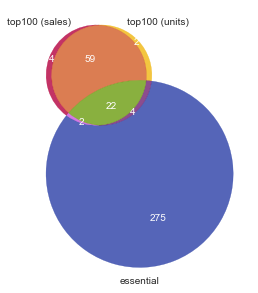

In [86]:
pt.three_circle_venn(set(top_100_sales_drugs.midrug_id.tolist()), set(top_100_units_drugs.midrug_id.tolist()),
                     set(essential_drugs.midrug_id.tolist()),
                     labels=('top100 (sales)', 'top100 (units)', 'essential'),
                     figsize=(5, 5), fontsize=10)

## How many genes in pharmacogene set have pharmacogenomics annotation in PharmGKB?

In [87]:
print len(set(set(targets_approved_drugs.gene_symbol.unique().tolist() + kozyra_genes + fujikura_genes))), "drug-related genes"
print len(set(targets_approved_drugs.gene_symbol.unique().tolist()) - set(pharmgkb_genes_all)) / float(targets_approved_drugs.gene_symbol.nunique()) 

816 drug-related genes
0.665094339623


### Overlap between genes listed in PharmGKB and drug-related genes

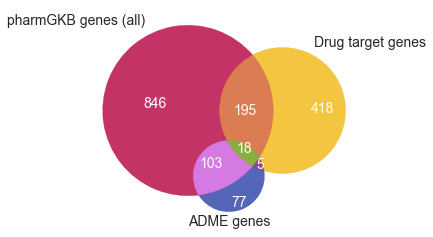

In [88]:
sets = pt.three_circle_venn(set(genes.loc[genes.symbol.isin(pharmgkb_genes_all)].symbol.unique()),
                  set(targets_approved_drugs.gene_symbol.unique().tolist()),
                  set(kozyra_genes + fujikura_genes),
                  labels=('pharmGKB genes (all)','Drug target genes', 
                  'ADME genes'),
                  figsize=(5, 5),
                  return_sets=True)

In [89]:
only_pharmgkb = genes.loc[genes.symbol.isin(list(set(pharmgkb_genes_all) -
                                                 set(targets_approved_drugs.gene_symbol.unique().tolist() +
                                                     kozyra_genes + fujikura_genes)))]
only_pharmgkb.to_csv(SUPPLEMENT_PATH + "only_pharmgkb_genes.txt", sep="\t", index=False)

### Significant associations from PharmGKB only

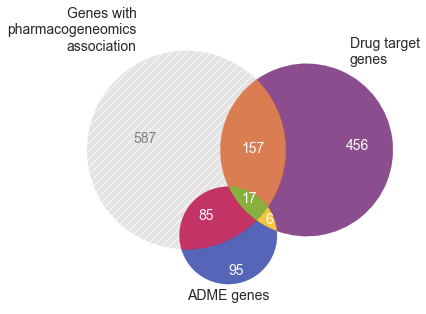

In [90]:
sets = pt.three_circle_venn(set(genes.loc[genes.symbol.isin(significant_genes)].symbol.unique()), # pharmgkb significant associations
                            set(targets_approved_drugs.gene_symbol.unique().tolist()),
                            set(kozyra_genes + fujikura_genes),
                            labels=('Genes with\npharmacogeneomics\nassociation','Drug target\ngenes', 
                                     'ADME genes'),
                            figsize=(10, 5),
                            return_sets=True,
                            colors={'set1': '#dddddd', 'set2': '#702072', 'set3': '#2A3FA6',
                             'set13': '#B5003E', 'set12': '#D35C27', 'set23': '#F0B710',
                             'set123': '#6C9C0F'}, hatch_set='100')
# plt.gcf().subplots_adjust(bottom=0.15, right=0.2, left=0.2 )

plt.savefig(RAW_FIGURE_PATH + "3circle_gene_dataset.pdf", dpi=300)

## How many drug - target associations have pharmacogenomics data

In [91]:
pharmgkb_pgx_data_all_drugids = pharmgkb_pgx_data.midrug_id.unique().tolist()

In [92]:
pharmgkb_pgx_data_filtered = pharmgkb_pgx_data.dropna(subset=["Gene Symbols"])

In [93]:
print len(pharmgkb_pgx_data), len(pharmgkb_pgx_data_filtered),
print len(pharmgkb_pgx_data_filtered.loc[pharmgkb_pgx_data_filtered.significance.str.contains("yes", na=False)])

18880 18011 5584


In [94]:
pharmgkb_pairs_extended = []
for _, row in pharmgkb_pgx_data_filtered.iterrows():
    for gene in row["gene_symbols"].split(','):
        pharmgkb_pairs_extended.append([row['midrug_id'], row['significance'], gene,
                                        row['variant_name'], row['association']])
pharmgkb_pairs_extended = pd.DataFrame(pharmgkb_pairs_extended, columns=["midrug_id", "significance", "symbol",
                                               "variants_name", "association"])\
    .merge(drugs[['midrug_id', 'name']], on='midrug_id')\
    .drop_duplicates()\
    .merge(genes[['hgnc_id', 'symbol']], on='symbol')\
    .drop_duplicates()
print len(pharmgkb_pairs_extended)

18861


In [95]:
pharmgkb_pairs_reduced = pharmgkb_pairs_extended[['midrug_id', 'hgnc_id']].drop_duplicates()

In [96]:
len(pharmgkb_pairs_reduced)

4905

In [97]:
pharmgkb_pairs = zip(pharmgkb_pairs_reduced["midrug_id"].tolist(), pharmgkb_pairs_reduced['hgnc_id'].tolist())

### Overlap between drug - target associations and any pharmacogenomic drug - gene relation

<matplotlib_venn._common.VennDiagram instance at 0x122650fc8>

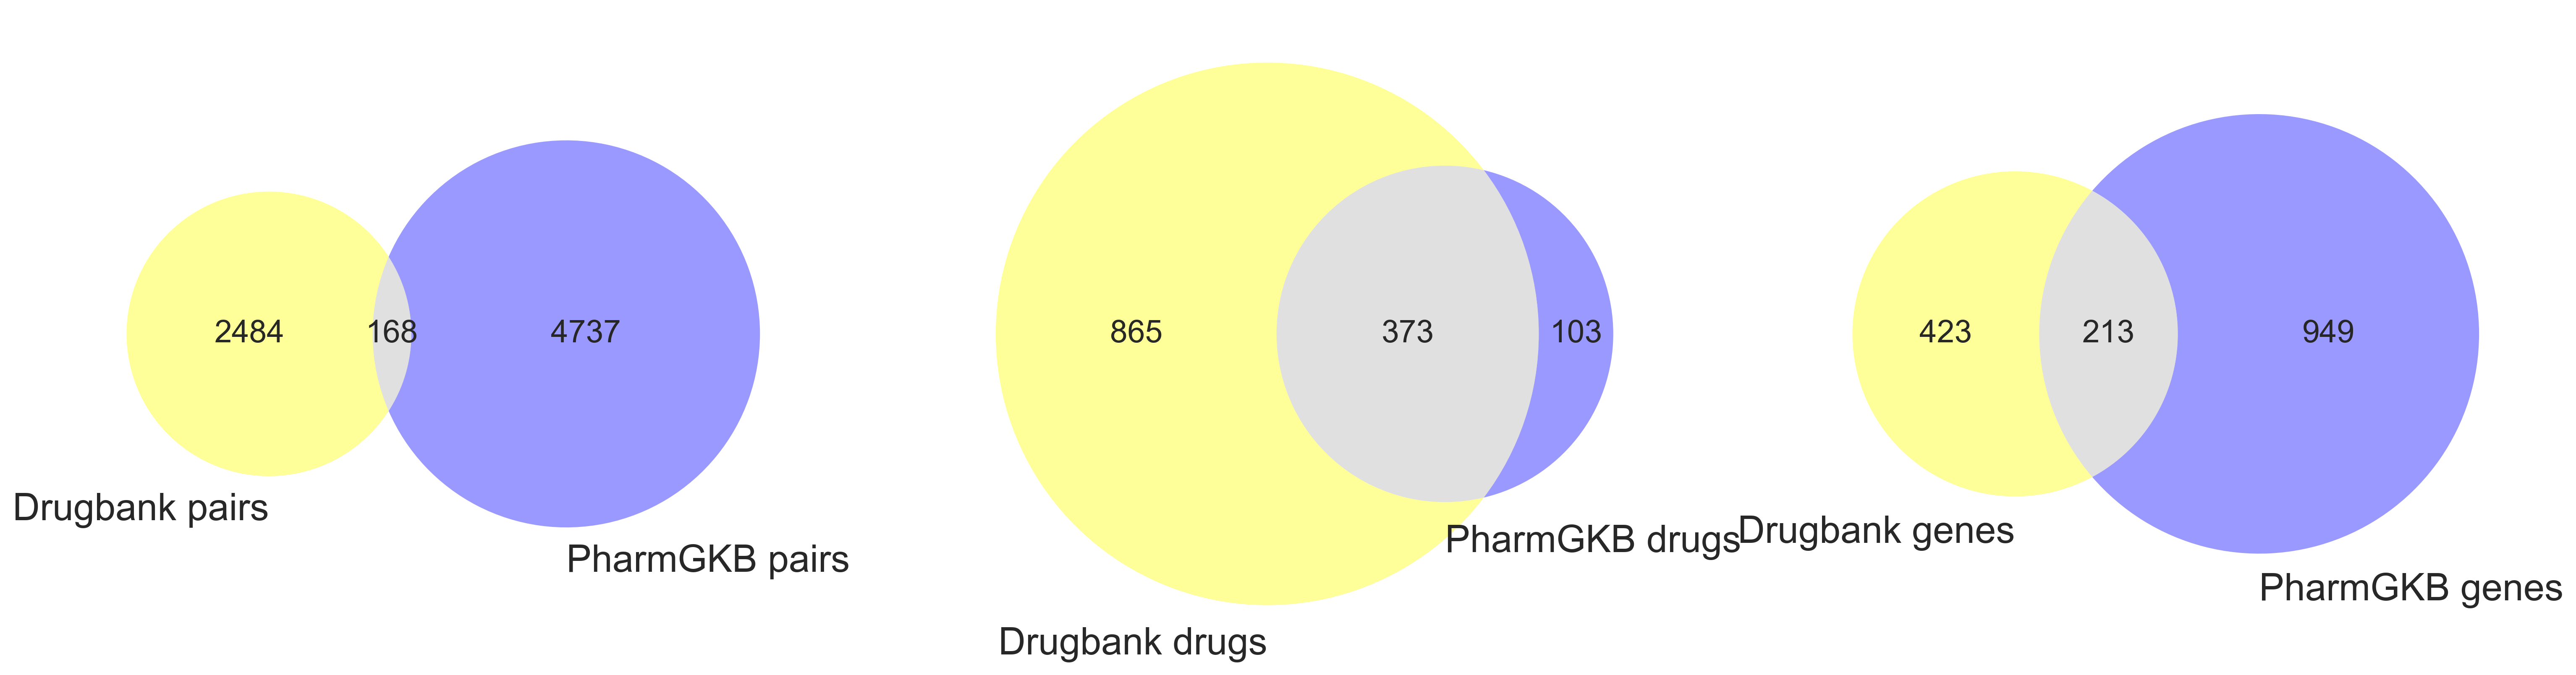

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7.5), dpi=300)
venn2([set(drugbank_pairs), set(pharmgkb_pairs)], ax=ax1,
      set_labels = ('Drugbank pairs', 'PharmGKB pairs'),
      set_colors=('yellow', 'blue'))
venn2([set(zip(*drugbank_pairs)[0]), set(zip(*pharmgkb_pairs)[0])], ax=ax2,
      set_labels = ('Drugbank drugs', 'PharmGKB drugs'),
      set_colors=('yellow', 'blue'))
venn2([set(zip(*drugbank_pairs)[1]), set(zip(*pharmgkb_pairs)[1])], ax=ax3,
      set_labels = ('Drugbank genes', 'PharmGKB genes'),
      set_colors=('yellow', 'blue'))

### Overlap between drug - target associations and significant pharmacogenomic drug - gene relation

In [99]:
pharmgkb_pairs_extended2 = pharmgkb_pairs_extended.loc[
    pharmgkb_pairs_extended.significance.str.contains('yes', na=False)]
pharmgkb_pairs_reduced2 = pharmgkb_pairs_extended2[['midrug_id', 'hgnc_id']].drop_duplicates()

In [100]:
len(pharmgkb_pairs_reduced2)

2966

In [101]:
pharmgkb_pairs_red = zip(pharmgkb_pairs_reduced2["midrug_id"].tolist(), pharmgkb_pairs_reduced2['hgnc_id'].tolist())

<matplotlib_venn._common.VennDiagram instance at 0x11dfe8ef0>

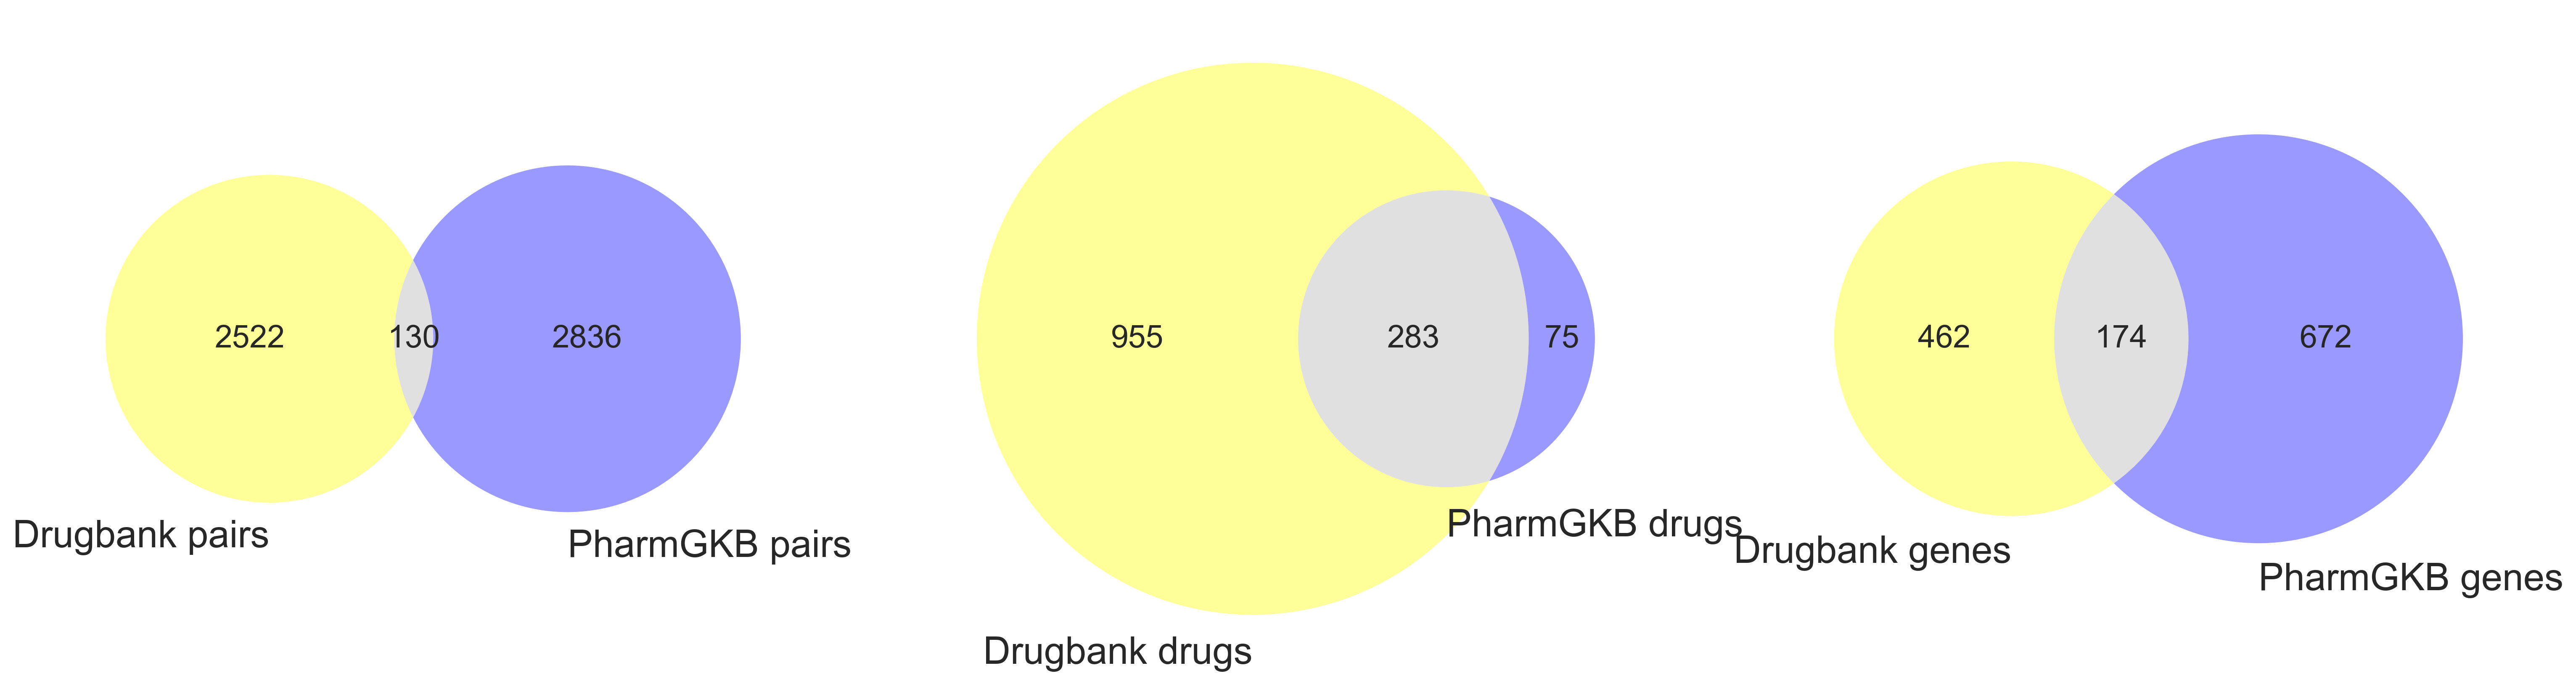

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7.5), dpi=300)
venn2([set(drugbank_pairs), set(pharmgkb_pairs_red)], ax=ax1,
      set_labels = ('Drugbank pairs', 'PharmGKB pairs'),
      set_colors=('yellow', 'blue'))
venn2([set(zip(*drugbank_pairs)[0]), set(zip(*pharmgkb_pairs_red)[0])], ax=ax2,
      set_labels = ('Drugbank drugs', 'PharmGKB drugs'),
      set_colors=('yellow', 'blue'))
venn2([set(zip(*drugbank_pairs)[1]), set(zip(*pharmgkb_pairs_red)[1])], ax=ax3,
      set_labels = ('Drugbank genes', 'PharmGKB genes'),
      set_colors=('yellow', 'blue'))

In [103]:
drug_targets_grouped = drug2gene_targets_approved_drugs.groupby('midrug_id')
new_df = []
pharmgkb_drugids = zip(*pharmgkb_pairs_red)[0]
for midrug_id, group in drug_targets_grouped:
    coverage = 0
    num_targets = float(group.hgnc_id.nunique())
    if midrug_id not in pharmgkb_drugids:
        if midrug_id not in pharmgkb_pgx_data_all_drugids:
            coverage = -1
            new_df.append([midrug_id, num_targets, coverage, 'drug missing in database'])
        else:
            coverage = -1
            new_df.append([midrug_id, num_targets, coverage, 'only non-coding variants'])
        continue
    
    num_covered = 0.
    for hgnc_id in group["hgnc_id"]:
        if (midrug_id, hgnc_id) in pharmgkb_pairs:
            num_covered += 1.
    coverage = num_covered/num_targets
    if coverage == 0.:
        new_df.append([midrug_id, num_targets, coverage, 'variants in non-target genes'])
    elif coverage < 1.:
        new_df.append([midrug_id, num_targets, coverage, 'targets partially covered'])
    else:
        new_df.append([midrug_id, num_targets, coverage, 'all targets covered'])   
new_df = pd.DataFrame(new_df, columns=["midrug_id", "num_targets", "coverage", "category"])

In [104]:
new_df.groupby(["category"]).agg({'midrug_id': lambda x: len(set(x))})

,midrug_id
category,
all targets covered,85
drug missing in database,862
only non-coding variants,93
targets partially covered,47
variants in non-target genes,151


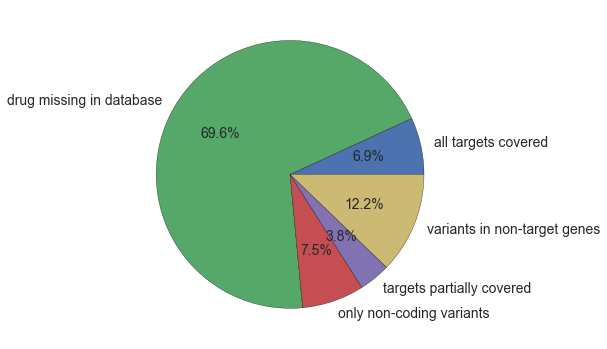

In [105]:
new_df.groupby(["category"]).agg({'midrug_id': lambda x: len(set(x))})["midrug_id"].plot.pie(figsize=(6, 6), autopct='%1.1f%%', fontsize=14)
plt.ylabel("");
# plt.savefig(RAW_FIGURE_PATH + "drugs_target_links_covered_pharmgkb_all.pdf", dpi=300)

In [106]:
top100_units_covarge_pharmgkb = new_df.merge(top_100_units_drugs, on="midrug_id").groupby(["category"])\
    .agg({'midrug_id': lambda x: len(set(x))})\
    .rename(columns={"midrug_id": "count"})

In [107]:
top100_units_covarge_pharmgkb

,count
category,
all targets covered,17
drug missing in database,23
only non-coding variants,8
targets partially covered,7
variants in non-target genes,22


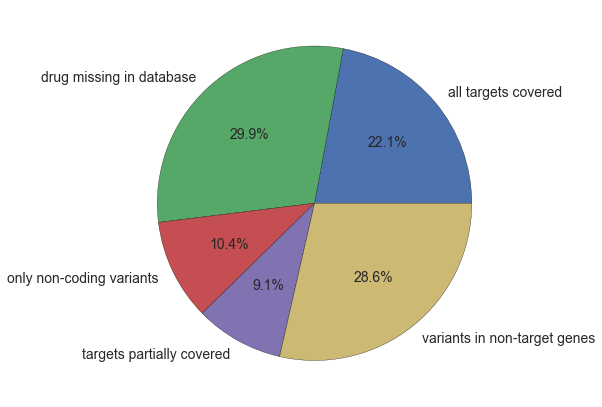

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
top100_units_covarge_pharmgkb["count"].plot.pie(autopct='%1.1f%%', fontsize=14, ax=ax)
plt.ylabel("")
plt.tight_layout()
# plt.savefig(RAW_FIGURE_PATH + "drugs_target_links_covered_pharmgkb_top100.pdf", dpi=300)

In [109]:
drug_targets_grouped = drug2gene_targets_approved_drugs.groupby('midrug_id')
covered_target = []
semi_covered_drugs = []
new_df = []
pharmgkb_drugids = zip(*pharmgkb_pairs_red)[0]
for midrug_id, group in drug_targets_grouped:
    coverage = 0
    num_targets = float(group.hgnc_id.nunique())
    if midrug_id not in pharmgkb_drugids:
        if midrug_id not in pharmgkb_pgx_data_all_drugids:
            coverage = -1
            new_df.append([midrug_id, num_targets, coverage, '1 drug missing in database'])
        else:
            coverage = -1
            new_df.append([midrug_id, num_targets, coverage, '2 only non-coding variants'])
            semi_covered_drugs.append(midrug_id)
        continue
    
    num_covered = 0.
    for hgnc_id in group["hgnc_id"]:
        if (midrug_id, hgnc_id) in pharmgkb_pairs:
            num_covered += 1.
            covered_target.append(hgnc_id)
    coverage = num_covered/num_targets
    if coverage == 0.:
        semi_covered_drugs.append(midrug_id)
        new_df.append([midrug_id, num_targets, coverage, '3 non-targets only'])
    elif coverage <= 1.:
        new_df.append([midrug_id, num_targets, coverage, '4 some targets'])

new_df = pd.DataFrame(new_df, columns=["midrug_id", "num_targets", "coverage", "category"])
covered_target = set(covered_target)

In [110]:
new_df.groupby(["category"]).agg({'midrug_id': lambda x: len(set(x))})\
    .rename(columns={"midrug_id": "count"})

,count
category,
1 drug missing in database,862
2 only non-coding variants,93
3 non-targets only,151
4 some targets,132


In [111]:
len(semi_covered_drugs)

244

In [112]:
targets_semi_covered_drugs = drug2gene_targets_approved_drugs.loc[drug2gene_targets_approved_drugs[('midrug_id', '')].isin(semi_covered_drugs)]

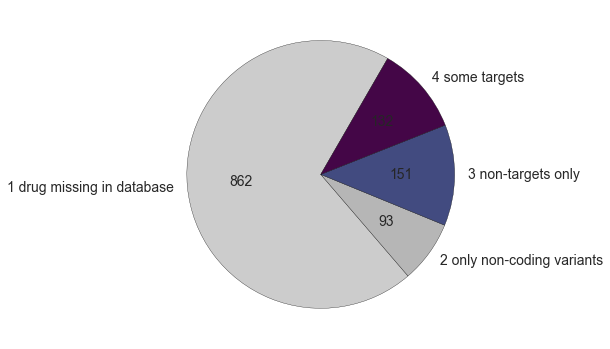

In [113]:
new_df_grouped = new_df.groupby(["category"]).agg({'midrug_id': lambda x: len(set(x))})["midrug_id"]
total = new_df_grouped.sum()
new_df_grouped.plot.pie(figsize=(6, 6), fontsize=14, cmap=cmap3, startangle=60,
                        autopct=lambda(p): '{:.0f}'.format(p * total / 100))
plt.ylabel("");
plt.savefig(RAW_FIGURE_PATH + "drugs_target_links_covered_pharmgkb_all_v2.pdf", dpi=300)

In [114]:
# drugs_pharmgkb_targets_covered = new_df.loc[new_df.coverage > 0.0]

# Create complete data set of drug-related genes

## ADME genes to drugs

In [115]:
# all ADME genes for approved drugs
drug2gene_adme_all = drug2gene_annot.loc[(drug2gene_annot.association_type != "target")]
drug2gene_adme_all_approved = drug2gene_adme_all.loc[drug2gene_adme_all.isFdaApproved == 1]
pharmacogenes_all_approved_drugs = reduce_drug2gene(drug2gene_adme_all_approved)

# established ADME genes for approved drugs
drug2gene_adme = drug2gene_annot.loc[(drug2gene_annot.association_type != "target") &
                                     (drug2gene_annot.target_known_action == 1)]
drug2gene_adme_approved = drug2gene_adme.loc[drug2gene_adme_all.isFdaApproved == 1]
pharmacogenes_approved_drugs = reduce_drug2gene(drug2gene_adme_approved)


In [116]:
print len(drug2gene_adme_all_approved), "ADME links for approved drugs", 
print "(", drug2gene_adme_all_approved.midrug_id.nunique(), "drugs,", 
print drug2gene_adme_all_approved.hgnc_id.nunique(), "genes)"

5134 ADME links for approved drugs ( 1150 drugs, 335 genes)


In [117]:
print len(drug2gene_adme_approved), "established ADME links for approved drugs", 
print "(", drug2gene_adme_approved.midrug_id.nunique(), "drugs,", 
print drug2gene_adme_approved.hgnc_id.nunique(), "genes)"

32 established ADME links for approved drugs ( 22 drugs, 23 genes)


## ADME + drug targets

In [118]:
drug2pharmacogene_all = drug2gene_targets_approved_drugs.append(drug2gene_adme_all_approved, ignore_index=True)

In [119]:
print len(drug2pharmacogene_all), "pharmacogene links for approved drugs", 
print "(", drug2pharmacogene_all.midrug_id.nunique(), "drugs,", 
print drug2pharmacogene_all.hgnc_id.nunique(), "genes)"

7786 pharmacogene links for approved drugs ( 1576 drugs, 925 genes)


In [120]:
drug2pharmacogene = drug2pharmacogene_all.loc[(drug2pharmacogene_all.association_type == 'target') |
                                              (drug2pharmacogene_all.hgnc_id.isin(pgx_genes_all))]

In [121]:
print len(drug2pharmacogene), "pharmacogene links for approved drugs", 
print "(", drug2pharmacogene.midrug_id.nunique(), "drugs,", 
print drug2pharmacogene.hgnc_id.nunique(), "genes (targets + fujikura + kozyra only))"

6996 pharmacogene links for approved drugs ( 1508 drugs, 737 genes (targets + fujikura + kozyra only))


## Combined

In [122]:
target_genes_df2 = genes.loc[genes.hgnc_id.isin(drug2gene_targets_approved_drugs.hgnc_id.unique())][["hgnc_id", "symbol", "uniprot_ids", "length"]]
target_genes_df2["group"] = "target"
target_genes_df2["subgroup"] = target_genes_df2["hgnc_id"].apply(lambda x: "cancer target"
                                                                 if x in drug2gene_onco_targets_approved_drugs.hgnc_id.tolist()
                                                                 else "target")
fujikura_genes_df2 = fujikura_genes_df[["hgnc_id", "symbol", "uniprot_ids", "length"]]
fujikura_genes_df2["group"] = "ADME"
fujikura_genes_df2["subgroup"] = "CYP450"
kozyra_genes_df2 = kozyra_genes_df[["hgnc_id", "symbol", "uniprot_ids", "length"]]
kozyra_genes_df2["group"] = "ADME"
kozyra_genes_df2["subgroup"] = kozyra_genes_df2["symbol"].apply(lambda x: kozyra_subgroup_dict.get(x))

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [123]:
pharmacogenes_df = pd.concat([target_genes_df2, kozyra_genes_df2, fujikura_genes_df2])\
    .groupby(["hgnc_id", "symbol", "uniprot_ids", "length"])\
    .agg({"group": lambda x: ", ".join(x), "subgroup": lambda x: ", ".join(map(str, x))})\
    .reset_index()

In [124]:
drug2gene_targets_approved_drugs.columns = drug2gene_targets_approved_drugs.columns.droplevel(1)

In [125]:
len(pharmacogenes_df)

816

# Exports

In [126]:
pharmacogenes_df.to_csv(SUPPLEMENT_PATH + "pharmacogenes_set.txt", index=False, sep="\t")

In [127]:
drug2gene_targets_approved_drugs.to_csv(SUPPLEMENT_PATH + "drug2gene_targets_approved_drugs.txt", index=False, sep="\t", encoding='utf-8')